### Carry out 'guided LDA'

In [1]:
import pickle
import pandas as pd
from newslda import NewsLDA 
from datetime import datetime
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

First we train the model using the news data from CryptoCompare's news API. 

In [2]:
df = pickle.load(open('newsdata.p', 'rb'))
df['document'] = df['title']+ ' ' + df['body']

INFO:guidedlda:n_documents: 47502
INFO:guidedlda:vocab_size: 1500
INFO:guidedlda:n_words: 1455481
INFO:guidedlda:n_topics: 18
INFO:guidedlda:n_iter: 500
/home/benhc/anaconda2/lib/python2.7/site-packages/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:guidedlda:<0> log likelihood: -14362354
INFO:guidedlda:<10> log likelihood: -10038664
INFO:guidedlda:<20> log likelihood: -9835414
INFO:guidedlda:<30> log likelihood: -9760241
INFO:guidedlda:<40> log likelihood: -9729292
INFO:guidedlda:<50> log likelihood: -9714346
INFO:guidedlda:<60> log likelihood: -9704774
INFO:guidedlda:<70> log likelihood: -9697215
INFO:guidedlda:<80> log likelihood: -9691481
INFO:guidedlda:<90> log likelihood: -9681045
INFO:guidedlda:<100> log likelihood: -9678846
INFO:guidedlda:<110> log likelihood: -96669

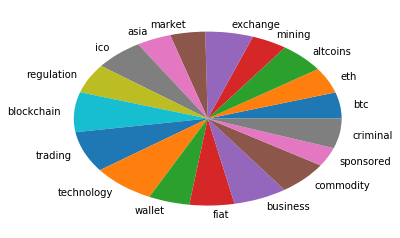

In [3]:
lda = NewsLDA(df['document'], alpha=0.1)
lda.guided_lda()

lda.display_assignment()

We can check that the topics seem sensible, and print example documents for specific topics. 

In [4]:
lda.display_topics(10)

Topic btc:
bitcoin news cash network post amp charts analysis guides fork
Topic eth:
ethereum network blockchain smart post new decentralized contracts eos lightning
Topic altcoins:
price analysis litecoin 2018 technical market 2017 eos iota btc
Topic mining:
mining crypto cryptocurrency bitcoin post media miners energy new power
Topic exchange:
exchange trading crypto cryptocurrency coinbase binance platform futures new post
Topic market:
price usd analysis technical bitcoin ripple key eth xrp support
Topic asia:
cryptocurrency south crypto exchanges exchange korea japan korean post japanese
Topic ico:
ico token sale platform post million pre tokens 2018 coin
Topic regulation:
crypto cryptocurrency icos sec securities new tax cryptocurrencies financial ico
Topic blockchain:
blockchain technology post based new conference world partnership global industry
Topic trading:
bitcoin price market cryptocurrency markets post time trading billion crypto
Topic technology:
blockchain platform in

In [5]:
lda.example_documents('btc', threshold=0.1)

Topic: btc
Bitcoin Cash Unveils Sharding Plans Shammah Chancellor, a developer at one of the main Bitcoin Cash client, BitcoinABC, detailed this Monday plans to implement vertical scaling in BCH by taking advantage of additional CPU cores for...The post Bitcoin Cash Unveils Sharding Plans appeared first on Trustnodes.

Bitcoin Cash Upgrade Debate: One CPU Equals One Vote If you are a Bitcoin Cash (BCH) proponent you’ve definitely been hearing a lot about the upcoming hard fork scheduled for November 15. Most people have been discussing the conflict between the Bitcoin ABC developers and Nchain’s recently announced Bitcoin SV project. This week Nchain’s Steve Shadders shared a post concerning the Bitcoin SV client [&#8230;]The post Bitcoin Cash Upgrade Debate: One CPU Equals One Vote appeared first on Bitcoin News.

Bitcoin Journalist Pioneer: Jamie Redman Has Over 2,000 Articles Published Journalist Jamie Redman is a pioneer. He&#8217;s one of first writers in the world to make his liv

Now let's make some visualisations. 

In [6]:
def separate_date(timestamp):
    return pd.to_datetime(timestamp, unit = 's')

In [7]:
# Remove allocations that arent significant - find the "main topics" 
thresh = 0.1 
def define_allocation(allocation):
    if allocation < thresh:
        return 0
    else:
        return allocation 

In [8]:
# Get the headline and publication date
df = df[['title', 'published_on']]
# lda.assigments contains all of the topic-document assignments
df_allocations = pd.DataFrame(lda.assignments, columns = lda.topic_names)
# Make a df with assignment information and date. 
df = pd.concat([df, df_allocations], axis=1)

df['published_on'] = df['published_on'].apply(separate_date)
for name in lda.topic_names:
    df[name] = df[name].apply(define_allocation)
    
df = df[df['published_on']>datetime(2017, 9, 21)]
# Look at weekly data to make weekday-weekend news spikes more smoothed. 
df_publications = df.groupby('published_on').sum().groupby(pd.Grouper(freq='W-Mon')).sum()
df_publications = df_publications[1:-1]

In [9]:
# Some familiar functions from the API quick start guide. 

def get_data(date):
    """ Query the API for 2000 days historical price data starting from "date". """
    url = "https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=2000&toTs={}".format(date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

def get_df(from_date, to_date):
    """ Get historical price data between two dates. """
    date = to_date
    holder = []
    # While the earliest date returned is later than the earliest date requested, keep on querying the API
    # and adding the results to a list. 
    while date > from_date:
        data = get_data(date)
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
    # Join together all of the API queries in the list.    
    df = pd.concat(holder, axis = 0)                    
    # Remove data points from before from_date
    df = df[df['time']>from_date]                       
    # Convert to timestamp to readable date format
    df['time'] = pd.to_datetime(df['time'], unit='s')   
    # Make the DataFrame index the time
    df.set_index('time', inplace=True)                  
    # And sort it so its in time order 
    df.sort_index(ascending=False, inplace=True)        
    return df

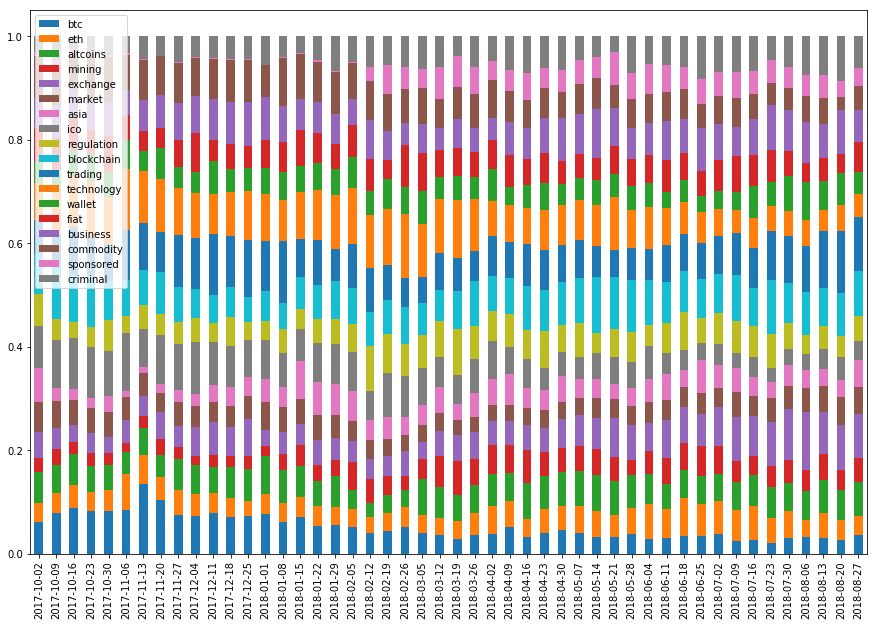

In [10]:
fig, ax = plt.subplots(figsize = (15, 10))
df_publications.divide(df_publications.sum(axis=1), axis=0).plot(kind='bar', stacked=True, ax=ax)
ax.legend(loc=2)
ax.set_xticklabels(df_publications.index.strftime("%Y-%m-%d"))
ax.set_xlabel("");

In [11]:
import seaborn as sns
sns.set_style("darkgrid")

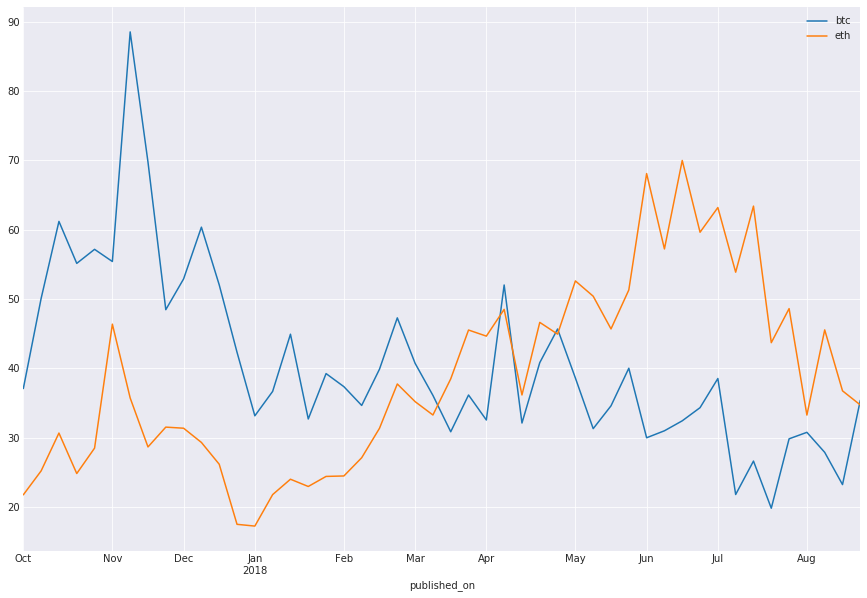

In [12]:
fig, ax = plt.subplots(figsize = (15, 10))
df_publications[['btc', 'eth']].plot(ax=ax)
ax.set_xlim([datetime(2017, 10, 1), datetime(2018, 8, 27)]);

In [13]:
df_price=get_df(1506816000, 1535328000)['close']

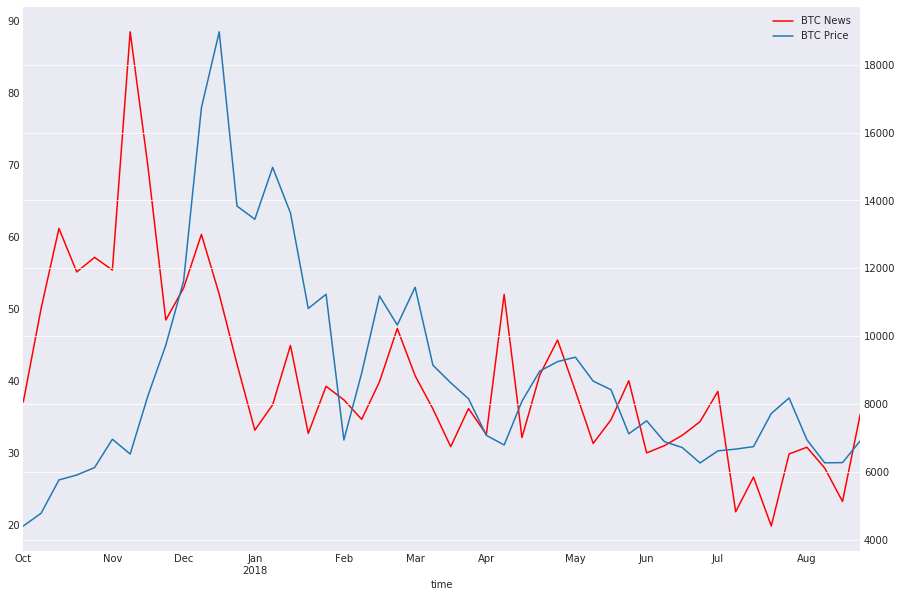

In [14]:
fig, ax = plt.subplots(figsize = (15, 10))
ax = df_publications['btc'].plot(label = 'BTC News', c='r')
ax2 = df_price.plot(ax=ax, secondary_y=True, label='BTC Price')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax.set_xlim([datetime(2017, 10, 1), datetime(2018, 8, 27)]);